In [1]:
import os
import numpy as np
import skimage
import matplotlib
import matplotlib.pyplot as plt
import cv2
import pickle
import math
import scipy.interpolate
from scipy.ndimage import gaussian_filter
from skimage import color
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
from pylab import cm
from mpl_toolkits.mplot3d import proj3d
from sklearn.neighbors import NearestNeighbors
from cp_hw5 import *

In [2]:
def imread(name):
    res = cv2.imread(name)
    res = res[...,::-1] # BGR to RGB
    return res

def imwrite(name, data):
    cv2.imwrite(name, data[:, :, ::-1])

In [3]:
SRC = "owl"
NUM_IMAGES = 5
NUM_REFERENCES = 3
SRC_DIR = f"../data/{SRC}"
OUT_DIR = f"../output/{SRC}"
RESIZE = 3

In [4]:
images = []
for i in range(NUM_IMAGES):
    fname = f"image{i+1}.jpg"
    path = f"{SRC_DIR}/{fname}"
    image = imread(path) / 255
    image = image[::RESIZE,::RESIZE,:]
    images.append(image)
images = np.stack(images)

HEIGHT = len(images[0])
WIDTH = len(images[0][0])

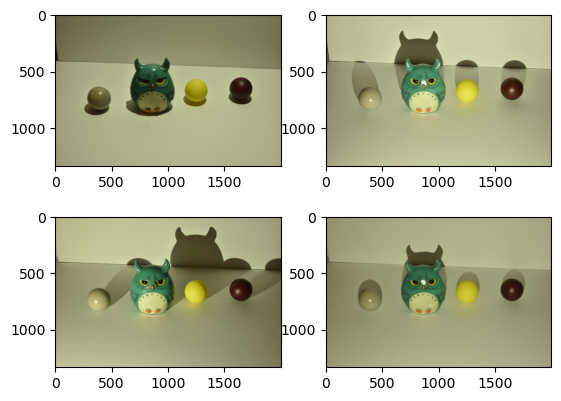

In [16]:
_, axs = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        axs[i][j].imshow(images[2*i+j])

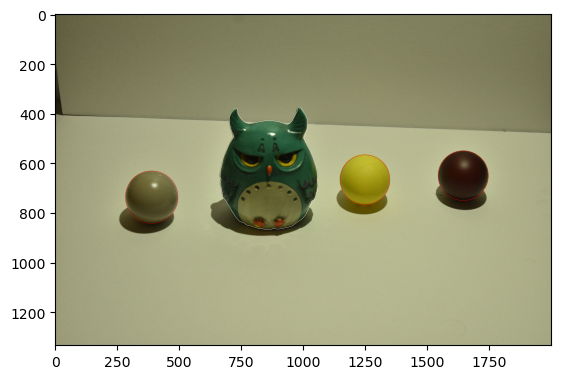

In [6]:
_, ax = plt.subplots()
ax.imshow(images[0])

# reference
center = [np.array([1165, 2210])/RESIZE, np.array([3746, 1998])/RESIZE, np.array([4935, 1950])/RESIZE]
radius = [318/RESIZE, 300/RESIZE, 300/RESIZE]
for i in range(len(center)):
    ax.add_patch(matplotlib.patches.Circle(center[i], radius[i], fill=False, color='red', linewidth=0.2))

# target
# source: https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
with open(f"{SRC_DIR}/object_mask.pickle", 'rb') as handle:
    tmp = pickle.load(handle)
    pts = []
    for i in range(len(tmp)):
        pt = (tmp[i][0] / RESIZE, tmp[i][1] / RESIZE)
        pts.append(pt)
ax.add_patch(matplotlib.patches.Polygon(pts, fill=False, color='white', linewidth=0.2))

In [7]:
def get_observation_vector(i, p): # p = array of coordinates in unit circle
    ix = (center[i][0] + radius[i] * p[:,0]).astype(int)
    iy = (center[i][1] + radius[i] * p[:,1]).astype(int)
    res = images[:,iy,ix] # NUM_IMAGES x NUM_PIXELS x 3
    res = np.swapaxes(res, 0, 1)
    res = np.reshape(res, (len(res), -1))
    return res

REFERENCE_SZ = 50
x, y = np.meshgrid(np.arange(REFERENCE_SZ), np.arange(REFERENCE_SZ))
x, y = x.flatten(), y.flatten()
x = (x - REFERENCE_SZ/2) / (REFERENCE_SZ/2)
y = (y - REFERENCE_SZ/2) / (REFERENCE_SZ/2)
reference_points = np.vstack((x,y)).T
reference_points = reference_points[np.linalg.norm(reference_points, axis=1) <= 1]

reference_observations = [] # NUM_REFERENCES x NUM_PIXELS x (NUM_IMAGES*3)
for i in range(NUM_REFERENCES):
    reference_observations.append(get_observation_vector(i, reference_points))
reference_observations = np.stack(reference_observations, axis=0)
print(reference_points.shape)
print(reference_observations.shape)

(1959, 2)
(3, 1959, 15)


In [8]:
# Used https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python
x, y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T

# Generate list of coordinates in target
# Used https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python
p = matplotlib.path.Path(pts) # make a polygon
grid = p.contains_points(points)
target_points = points[grid]

target_observations = images[:,target_points[:,1],target_points[:,0],:] # NUM_IMAGES x NUM_TARGET_PIXELS x 3
target_observations = np.swapaxes(target_observations, 0, 1) # NUM_TARGET_PIXELS x NUM_IMAGES x 3
target_observations = np.reshape(target_observations, (len(target_observations), -1))

print(target_points.shape)
print(target_observations.shape)

(146406, 2)
(146406, 15)


In [9]:
reference_observations = np.swapaxes(reference_observations, 0, 1)
reference_observations = np.swapaxes(reference_observations, 1, 2)
print(reference_observations.shape) # NUM_PIXELS x (NUM_IMAGES*3) x NUM_REFERENCES
# this is also the W matrix in the paper

(1959, 15, 3)


In [10]:
# For each target observation vector, find m using pseudoinverse
pinvs = []
for q in range(len(reference_observations)):
    pinvs.append(np.linalg.pinv(reference_observations[q]))

indices = []
for p in range(len(target_observations)):
    if p % 10000 == 0:
        print(p)
    v = target_observations[p]
    min_norm = 1e18
    best_index = 0
    for q in range(len(reference_observations)):
        w = reference_observations[q]
        m = pinvs[q] @ v
        norm = np.linalg.norm(w @ m - v) ** 2
        if norm < min_norm:
            min_norm = norm
            best_index = q
    indices.append(best_index)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


In [11]:
indices = np.array(indices)
coords = reference_points[indices]
z_coords = np.sqrt(1-np.linalg.norm(coords,axis=1)**2)
normals = np.stack([coords[:,0], coords[:,1], z_coords], axis=1)
print(normals.shape)

(146406, 3)


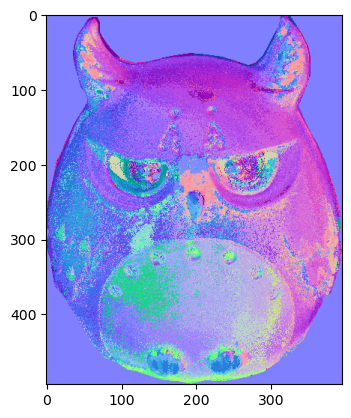

In [12]:
rect = cv2.boundingRect(target_points)
x,y,w,h = rect
normal_map = np.zeros((h,w,3))
normal_map[:,:,2] = 1 # for background just point towards us
for i in range(len(target_points)):
     normal_map[target_points[i][1]-y][target_points[i][0]-x] = normals[i]
plt.imshow((normal_map+1)/2)

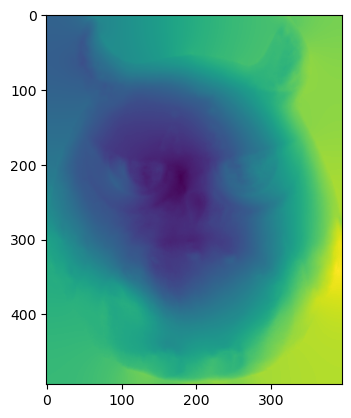

In [13]:
def get_heightmap(normals):
    eps = 0.5
    dfdx = normals[:,:,0] / (normals[:,:,2] + eps)
    dfdy = normals[:,:,1] / (normals[:,:,2] + eps)
    heights = integrate_poisson(dfdx, dfdy)
    heights = (heights - heights.min()) / (heights.max() - heights.min())
    return heights
heights = get_heightmap(normal_map)
plt.imshow(heights)
with open(f"{OUT_DIR}/heights.pickle", 'wb') as handle:
    pickle.dump(heights, handle)

C:\Users\Ldori\AppData\Local\Temp\ipykernel_4368\2122969093.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


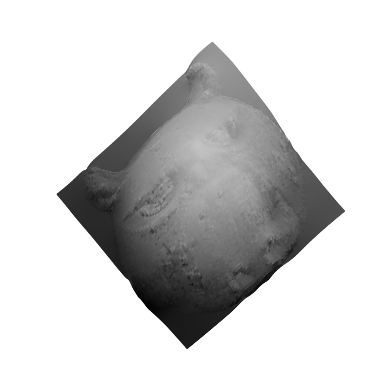

In [14]:
def plot_surface(name, Z, height, angle):
    # Z is an HxW array of surface depths
    H, W = Z.shape
    x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
    # set 3D figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # add a light and shade to the axis for visual effect
    # (use the ‘-’ sign since our Z-axis points down)
    ls = LightSource()
    color_shade = ls.shade(-Z, plt.cm.gray)
    # display a surface
    # (control surface resolution using rstride and cstride)
    surf = ax.plot_surface(x, y, -Z, facecolors=color_shade, rstride=4, cstride=4)
    ax.view_init(elev=height, azim=angle)
    # turn off axis
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()

plot_surface(None, heights, 70, 50)